# Séries temporelles et map reduce

Map/Reduce est un concept qui permet de distribuer les données facilement si elles sont indépendantes. C'est une condition qu'une série temporelle ne vérifie pas du fait de la dépendance temporelle. Voyons ce que cela change.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
# Répare une incompatibilité entre scipy 1.0 et statsmodels 0.8.
from pymyinstall.fix import fix_scipy10_for_statsmodels08
fix_scipy10_for_statsmodels08()

On souhaite simplement calculer la dérivée de la série temporelle : $\Delta Y_t = Y_t - Y_{t-1}$.

In [3]:
%matplotlib inline

## Data

In [4]:
from pyensae.finance import StockPrices
stock = StockPrices("MSFT", folder=".", url="yahoo")
stock.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2018-04-02,2018-04-02,90.470001,90.879997,87.510002,88.519997,88.519997,48515400
2018-04-03,2018-04-03,89.580002,90.050003,87.889999,89.709999,89.709999,37213800
2018-04-04,2018-04-04,87.849998,92.760002,87.730003,92.330002,92.330002,35560000
2018-04-05,2018-04-05,92.440002,93.070000,91.400002,92.379997,92.379997,29771900
2018-04-06,2018-04-06,91.489998,92.459999,89.480003,90.230003,90.230003,37688200


On crée une colonne supplémentaire pour l'indice $t$ de la série temporelle :

In [5]:
dt = stock.df()
dt = dt[["Close"]]
dt = dt.reset_index(drop=True)
data = dt
dt.tail()

,Close
4589,88.519997
4590,89.709999
4591,92.330002
4592,92.379997
4593,90.230003


La fonction [shift](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html) rend le calcul très simple avec pandas.

In [6]:
data_pandas = data.copy()
data_pandas["Close2"] = data.shift(1)
data_pandas["delta"] = data_pandas["Close"] - data_pandas["Close2"]
data_pandas.tail()

,Close,Close2,delta
4589,88.519997,91.269997,-2.750000
4590,89.709999,88.519997,1.190002
4591,92.330002,89.709999,2.620003
4592,92.379997,92.330002,0.049995
4593,90.230003,92.379997,-2.149994


La fonction est très rapide car elle utilise l'ordre des données et son index. Pour s'en passer, on ajoute une colonne qui contient l'index original puis on mélange pour simuler le fait qu'en map/reduce, l'ordre des informations n'est pas connu à l'avance.

In [7]:
import numpy
data = dt.reindex(numpy.random.permutation(data.index))
data = data.reset_index(drop=False)
data.columns = ["t", "close"]
data.tail()

,t,close
4589,594,28.014999
4590,3287,28.010000
4591,3955,43.869999
4592,1176,27.280001
4593,829,25.490000


## Dérivée avec pandas

Le traitement de chaque ligne est indépendant et ne doit pas prendre en compte aucune autre ligne mais on a besoin de $Y_{t-1}$ pour calculer $\Delta Y_t$. 

In [8]:
data["tt"] = data["t"] - 1 

### méthode efficace

Lors d'une jointure, [pandas](http://pandas.pydata.org/) va trier chaque côté de la jointure par ordre croissant de clé. S'il y a $N$ observations, cela a un coût de $N\ln N$, il réalise ensuite une fusion des deux bases en ne considérant que les lignes partageant la même clé. Cette façon de faire ne convient que lorsqu'on fait une jointure avec une condition n'incluant que des ET logique et des égalités.

In [9]:
join = data.merge(data, left_on="t", right_on="tt", suffixes=("", "2"))
join.tail()

,t,close,tt,t2,close2,tt2
4588,594,28.014999,593,595,27.004999,594
4589,3287,28.010000,3286,3288,27.850000,3287
4590,3955,43.869999,3954,3956,43.910000,3955
4591,1176,27.280001,1175,1177,27.490000,1176
4592,829,25.490000,828,830,25.219999,829


In [10]:
derivee = join.copy()
derivee["derivee"] = derivee["close"] - derivee["close2"]
derivee.tail()

,t,close,tt,t2,close2,tt2,derivee
4588,594,28.014999,593,595,27.004999,594,1.010000
4589,3287,28.010000,3286,3288,27.850000,3287,0.160000
4590,3955,43.869999,3954,3956,43.910000,3955,-0.040001
4591,1176,27.280001,1175,1177,27.490000,1176,-0.209999
4592,829,25.490000,828,830,25.219999,829,0.270001


En résumé :

In [11]:
new_data = data.copy()
new_data["tt"] = new_data["t"] + 1  # MAP
new_data = new_data.merge(new_data, left_on="t", right_on="tt", suffixes=("", "2")) # JOIN = SORT + MAP + REDUCE
new_data["derivee"] = new_data["close"] - new_data["close2"] # MAP
print(new_data.shape)
new_data.tail()

(4593, 7)


,t,close,tt,t2,close2,tt2,derivee
4588,594,28.014999,595,593,27.870001,594,0.144998
4589,3287,28.010000,3288,3286,27.910000,3287,0.100000
4590,3955,43.869999,3956,3954,43.900002,3955,-0.030003
4591,1176,27.280001,1177,1175,27.260000,1176,0.020001
4592,829,25.490000,830,828,25.719999,829,-0.229999


### mesure de coût

La série n'est pas assez longue pour observer la relation entre le temps de calcul et le nombre d'observations.

In [12]:
def derive(data):
    new_data = data.copy()
    new_data["tt"] = new_data["t"] + 1  # MAP
    new_data = new_data.merge(new_data, left_on="t", right_on="tt", suffixes=("", "2")) # JOIN = MAP + REDUCE
    new_data["derivee"] = new_data["close"] - new_data["close2"] # MAP
    return new_data

On choisit une régression linéaire de type [HuberRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html#sklearn.linear_model.HuberRegressor) pour régresser $C(N) \sim a N + b \ln N + c N \ln N + d$. Ce modèle est beaucoup moins sensible aux points aberrants que les autres formes de régressions. On utilise cette régression avec le module [RobustLinearModels](http://statsmodels.sourceforge.net/stable/rlm.html) du module *statsmodels* pour calculer les p-values

c:\python364_x64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(91,) <class 'pandas.core.series.Series'>
                    Robust linear Model Regression Results                    
Dep. Variable:        processing time   No. Observations:                   91
Model:                            RLM   Df Residuals:                       87
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 09 Apr 2018                                         
Time:                        23:05:22                                         
No. Iterations:                    30                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
logN      

c:\python364_x64\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


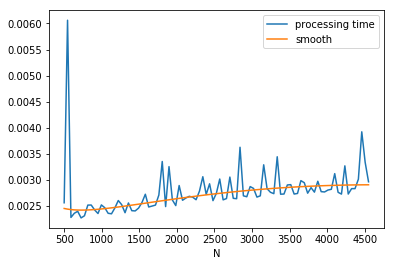

In [13]:
import time, pandas, numpy, sklearn.linear_model as lin
import matplotlib.pyplot as plt
import statsmodels.api as smapi
from random import randint

def graph_cout(data, h=100, nb=10, add_n2=False, derive=derive):
    dh = len(data) // h
    res = []
    for n in range(max(dh, 500), len(data), dh):
        df = data[0:n+randint(-10,10)]
        mean = []
        for i in range(0, nb):
            t = time.clock()
            derive(df)
            dt = time.clock() - t
            mean.append(dt)
        res.append((n, mean[len(mean)//2]))
    # stat
    stat = pandas.DataFrame(res, columns=["N", "processing time"])
    stat["logN"] = numpy.log(stat["N"]) / numpy.log(10)
    stat["NlogN"] = stat["N"] * stat["logN"]
    stat["N2"] = stat["N"] * stat["N"]
    # statsmodels
    stat["one"] = 1
    X = stat[["logN", "N", "NlogN", "N2", "one"]]
    if not add_n2:
        X = X.drop("N2", axis=1)
    rlm_model = smapi.RLM(stat["processing time"], X, M=smapi.robust.norms.HuberT())
    rlm_results = rlm_model.fit()
    yp = rlm_results.predict(X)
    print(yp.shape, type(yp))
    stat["smooth"] = yp
    # graph
    fig, ax = plt.subplots()
    stat.plot(x="N", y=["processing time", "smooth"], ax=ax)
    return ax, rlm_results

ax, results = graph_cout(data)
print(results.summary())
ax;

Le coût de l'algorithme est au moins linéaire. Cela signifie que le coût du calcul qu'on cherche à mesurer est noyé dans plein d'autres choses non négligeable. La valeur des coefficients n'indique pas grand chose car les variables $N$, $Nlog N$ évoluent sur des échelles différentes.

(24,) <class 'pandas.core.series.Series'>
                    Robust linear Model Regression Results                    
Dep. Variable:        processing time   No. Observations:                   24
Model:                            RLM   Df Residuals:                       20
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 09 Apr 2018                                         
Time:                        23:06:20                                         
No. Iterations:                    50                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
logN      

c:\python364_x64\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


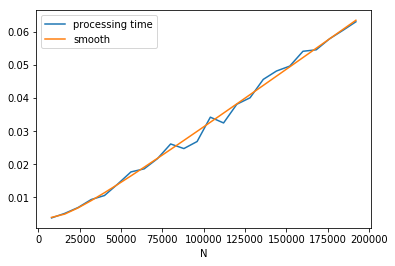

In [14]:
N = 200000
from random import random
data2 = pandas.DataFrame({"t":range(0,N), "close": [random() for i in range(0, N)]})
ax, stats = graph_cout(data2, h=25)
print(stats.summary())
ax;

Les résultats sont assez volatiles. Il faut regarder les intervalles de confiance et regarder lesquels n'incluent pas 0.

### méthode inefficace

Dans ce cas, on fait un produit en croix de toutes les lignes de la bases avec elles-même puis on filtre le résultat pour ne garder que les lignes qui vérifient la condition souhaitée quelle qu'elle soit. Le temps d'exécution est en $O(N^2)$ et la différence est vite significative.

In [15]:
new_data2 = data.copy()
new_data2["tt"] = new_data2["t"] + 1  # MAP
new_data2["key"] = 1
new_data2 = new_data2.merge(new_data2, on="key", suffixes=("", "2")) # JOIN = MAP^2
print(new_data2.shape)
new_data2 = new_data2[new_data2.t == new_data2.t2] # MAP
print(new_data2.shape)
new_data2["derivee"] = new_data2["t"] - new_data2["t2"] # MAP
new_data2.tail()

(21104836, 7)
(4594, 7)


,t,close,tt,key,t2,close2,tt2,derivee
21086455,594,28.014999,595,1,594,28.014999,595,0
21091050,3287,28.010000,3288,1,3287,28.010000,3288,0
21095645,3955,43.869999,3956,1,3955,43.869999,3956,0
21100240,1176,27.280001,1177,1,1176,27.280001,1177,0
21104835,829,25.490000,830,1,829,25.490000,830,0


### mesure de coût inefficace

(9,) <class 'pandas.core.series.Series'>
                    Robust linear Model Regression Results                    
Dep. Variable:        processing time   No. Observations:                    9
Model:                            RLM   Df Residuals:                        4
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 09 Apr 2018                                         
Time:                        23:07:37                                         
No. Iterations:                    33                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
logN       

c:\python364_x64\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


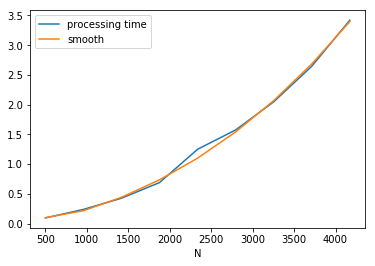

In [16]:
def derive_inefficace(data):
    new_data2 = data.copy()
    new_data2["tt"] = new_data2["t"] + 1
    new_data2["key"] = 1
    new_data2 = new_data2.merge(new_data2, on="key", suffixes=("", "2"))
    new_data2 = new_data2[new_data2.t == new_data2.t2]
    new_data2["derivee"] = new_data2["t"] - new_data2["t2"] # MAP
    return new_data2

ax, stats = graph_cout(data, h=10, nb=5, derive=derive_inefficace, add_n2=True)
print(stats.summary())
ax;

## avec des itérateurs

### version efficace

In [17]:
rows = data[["t", "close"]].itertuples()
list(rows)[:2]

[Pandas(Index=0, t=4479, close=78.809998),
 Pandas(Index=1, t=2227, close=21.299999)]

In [18]:
rows = data[["t", "close"]].itertuples()
rows = map(lambda r: (r.t, r.close, r.t+1), rows)
list(rows)[:2]

[(4479, 78.809998, 4480), (2227, 21.299999, 2228)]

In [19]:
import copy
from cytoolz.itertoolz import join
rows = data[["t", "close"]].itertuples()
rows = map(lambda r: (r.t, r.close, r.t+1), rows)
rows = join(lambda t: t[2], rows, lambda t: t[0], copy.deepcopy(rows))
rows = map(lambda tu: tu[0] + tu[1], rows)
rows = map(lambda row: (row[0], row[4] - row[1]), rows)
results = list(rows)
results[:2]

[(4478, 0.8999939999999924), (2226, -0.20000100000000032)]

### version inefficace

La méthode inefficace avec *pandas* est particulièrement inefficace car elle nécessite de stocker un tableau intermédiaire qui contient $N^2$ lignes.

In [20]:
import copy
from cytoolz.itertoolz import join
rows = data[["t", "close"]].itertuples()
rows = map(lambda r: (r.t, r.close, r.t+1, 1), rows)   # on ajoute 1
rows = join(lambda t: t[-1], rows, lambda t: t[-1], copy.deepcopy(rows))  # on fait un produit croisé
rows = map(lambda tu: tu[0] + tu[1], rows)
rows = filter(lambda t: t[2] == t[4], rows)     # on filtre les lignes qui nous intéresse
rows = map(lambda row: (row[0], row[5] - row[1]), rows)
results = list(rows)   # c'est très lent
results[:4]

[(4478, 0.8999939999999924),
 (2226, -0.20000100000000032),
 (909, 0.9199999999999982),
 (4511, -0.29000100000000373)]

## avec SQL

### conversion du dataframe au format SQL

In [21]:
data = stock.df()
data.columns = [_.replace(" ", "_") for _ in data.columns]
data = data.reset_index(drop=True).reset_index(drop=False)
data.columns = ["t"] + list(data.columns[1:])
data.head()

,t,Date,Open,High,Low,Close,Adj_Close,Volume
0,0,2000-01-03,58.68750,59.3125,56.00000,58.28125,42.826191,53228400
1,1,2000-01-04,56.78125,58.5625,56.12500,56.31250,41.379513,54119000
2,2,2000-01-05,55.56250,58.1875,54.68750,56.90625,41.815826,64059600
3,3,2000-01-06,56.09375,56.9375,54.18750,55.00000,40.415058,54976600
4,4,2000-01-07,54.31250,56.1250,53.65625,55.71875,40.943214,62013600


In [22]:
import sqlite3
con = sqlite3.connect(":memory:")
tbl = data.to_sql("stock", con, index=False)

In [23]:
%load_ext pyensae

In [24]:
%SQL_tables -v con

['stock']

In [25]:
%%SQL -v con

SELECT * FROM stock LIMIT 5

,t,Date,Open,High,Low,Close,Adj_Close,Volume
0,0,2000-01-03,58.68750,59.3125,56.00000,58.28125,42.826191,53228400
1,1,2000-01-04,56.78125,58.5625,56.12500,56.31250,41.379513,54119000
2,2,2000-01-05,55.56250,58.1875,54.68750,56.90625,41.815826,64059600
3,3,2000-01-06,56.09375,56.9375,54.18750,55.00000,40.415058,54976600
4,4,2000-01-07,54.31250,56.1250,53.65625,55.71875,40.943214,62013600


### version efficace

L'instruction ``ON`` précise sur quelle ou quelles colonnes opérer la fusion. 

In [26]:
%%SQL -v con

SELECT A.t AS t, A.Close AS Close, A.tt AS tt,
       B.t AS t2, B.Close AS Close2, B.tt AS tt2
FROM (
    SELECT t, Close, t+1 AS tt FROM stock
    ) AS A
INNER JOIN (
    SELECT t, Close, t+1 AS tt FROM stock
    ) AS B
ON A.tt == B.t

,t,Close,tt,t2,Close2,tt2
0,0,58.28125,1,1,56.31250,2
1,1,56.31250,2,2,56.90625,3
2,2,56.90625,3,3,55.00000,4
3,3,55.00000,4,4,55.71875,5
4,4,55.71875,5,5,56.12500,6
5,5,56.12500,6,6,54.68750,7
6,6,54.68750,7,7,52.90625,8
7,7,52.90625,8,8,53.90625,9
8,8,53.90625,9,9,56.12500,10
9,9,56.12500,10,10,57.65625,11


### version inefficace

Pour la version inefficace, l'instruction ``JOIN`` effectue tous les combinaisons de lignes possibles, soit $N^2$. Le mot-clé ``WHERE`` garde les couples de lignes qui nous intéresse.

In [27]:
%%SQL -v con

SELECT A.t AS t, A.Close AS Close, A.tt AS tt,
       B.t AS t2, B.Close AS Close2, B.tt AS tt2
FROM (
    SELECT t, Close, t+1 AS tt FROM stock
    ) AS A
INNER JOIN (
    SELECT t, Close, t+1 AS tt FROM stock
    ) AS B
WHERE A.tt >= B.t AND A.tt <= B.t -- on écrit l'égalité comme ceci pour contourner les optimisations
                                  -- réalisée par SQLlite

,t,Close,tt,t2,Close2,tt2
0,0,58.28125,1,1,56.31250,2
1,1,56.31250,2,2,56.90625,3
2,2,56.90625,3,3,55.00000,4
3,3,55.00000,4,4,55.71875,5
4,4,55.71875,5,5,56.12500,6
5,5,56.12500,6,6,54.68750,7
6,6,54.68750,7,7,52.90625,8
7,7,52.90625,8,8,53.90625,9
8,8,53.90625,9,9,56.12500,10
9,9,56.12500,10,10,57.65625,11
